<a href="https://colab.research.google.com/github/TAEWOOYOON/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/ch04_05_WaveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.05 Wave Net

* 날짜: 2022.08.23
* 이름: 윤태우

## 학습내용
    - Audio data에 대해 이해한다.
    - 머신러닝 방법으로 접근하여 문제를 해결해 본다.
    - 딥러닝 네트워크를 이용해 문제를 해결한다.
    - waveNet, yamNet 등 딥러닝 알고리즘을 적용한다.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os
import tensorflow as tf
from tensorflow.keras import models, layers, utils, losses, optimizers
import seaborn as sns
sys.path.append('/content/drive/MyDrive/script')

## 데이터셋 - Kaggle GTZAN Dataset 
---

https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification



### **| kaggle 데이터 연동**


1. kaggle 로그인 - my account - API Create New Api Token - `kaggle.json` 파일 다운로드
2. Drive에 저장해 놓는것을 권장
3. kaggle 패키지 다운로드
```
! pip install kaggle
```
4. 권한 변경
```
! chmod 600 `드라이브 파일 경로`
```
5. `~/` 위치에 복사
```
! cp `드라이브 파일 경로` ~/.kaggle/
```

6. 데이터셋 다운로드
```
! kaggle datasets download 데이터주소
```

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! chmod 600 /content/drive/MyDrive/script/kaggle.json

In [ ]:
ls -a /root

./   .bashrc*  .config/   .jupyter/  .keras/  .npm/     .tmux.conf*
../  .cache/   .ipython/  .kaggle/   .local/  .profile  .wget-hsts


In [ ]:
mkdir ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [ ]:
! cp /content/drive/MyDrive/script/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification

gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip /content/gtzan-dataset-music-genre-classification.zip

Archive:  /content/gtzan-dataset-music-genre-classification.zip
replace Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ;[;
error:  invalid response [;[;]
replace Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: hjy
error:  invalid response [hjy]
replace Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Data/features_3_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Data/genres_original/blues/blues.00000.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Data/genres_original/blues/blues.00001.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Data/genres_original/blues/blues.00002.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Data/genres_original/blues/blues.00003.wav? [y]es, [n]o, [A]ll, [N]one, [r]

### **| EDA**

In [ ]:
df = pd.read_csv('/content/Data/features_30_sec.csv')
print(df.shape)
df.head()

(1000, 60)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


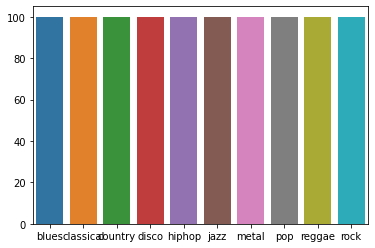

In [ ]:
# 예측해야할 클래스

class_count = df['label'].value_counts()
sns.barplot(x=class_count.index, y = class_count.values)

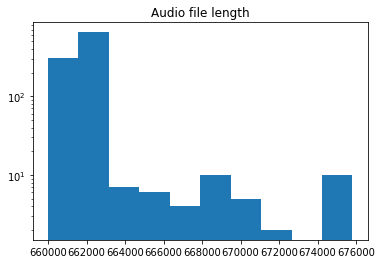

In [ ]:
# 음성 파일의 길이
plt.title('Audio file length')
plt.hist(df['length'], log = True)
plt.show()

feature counts :  57


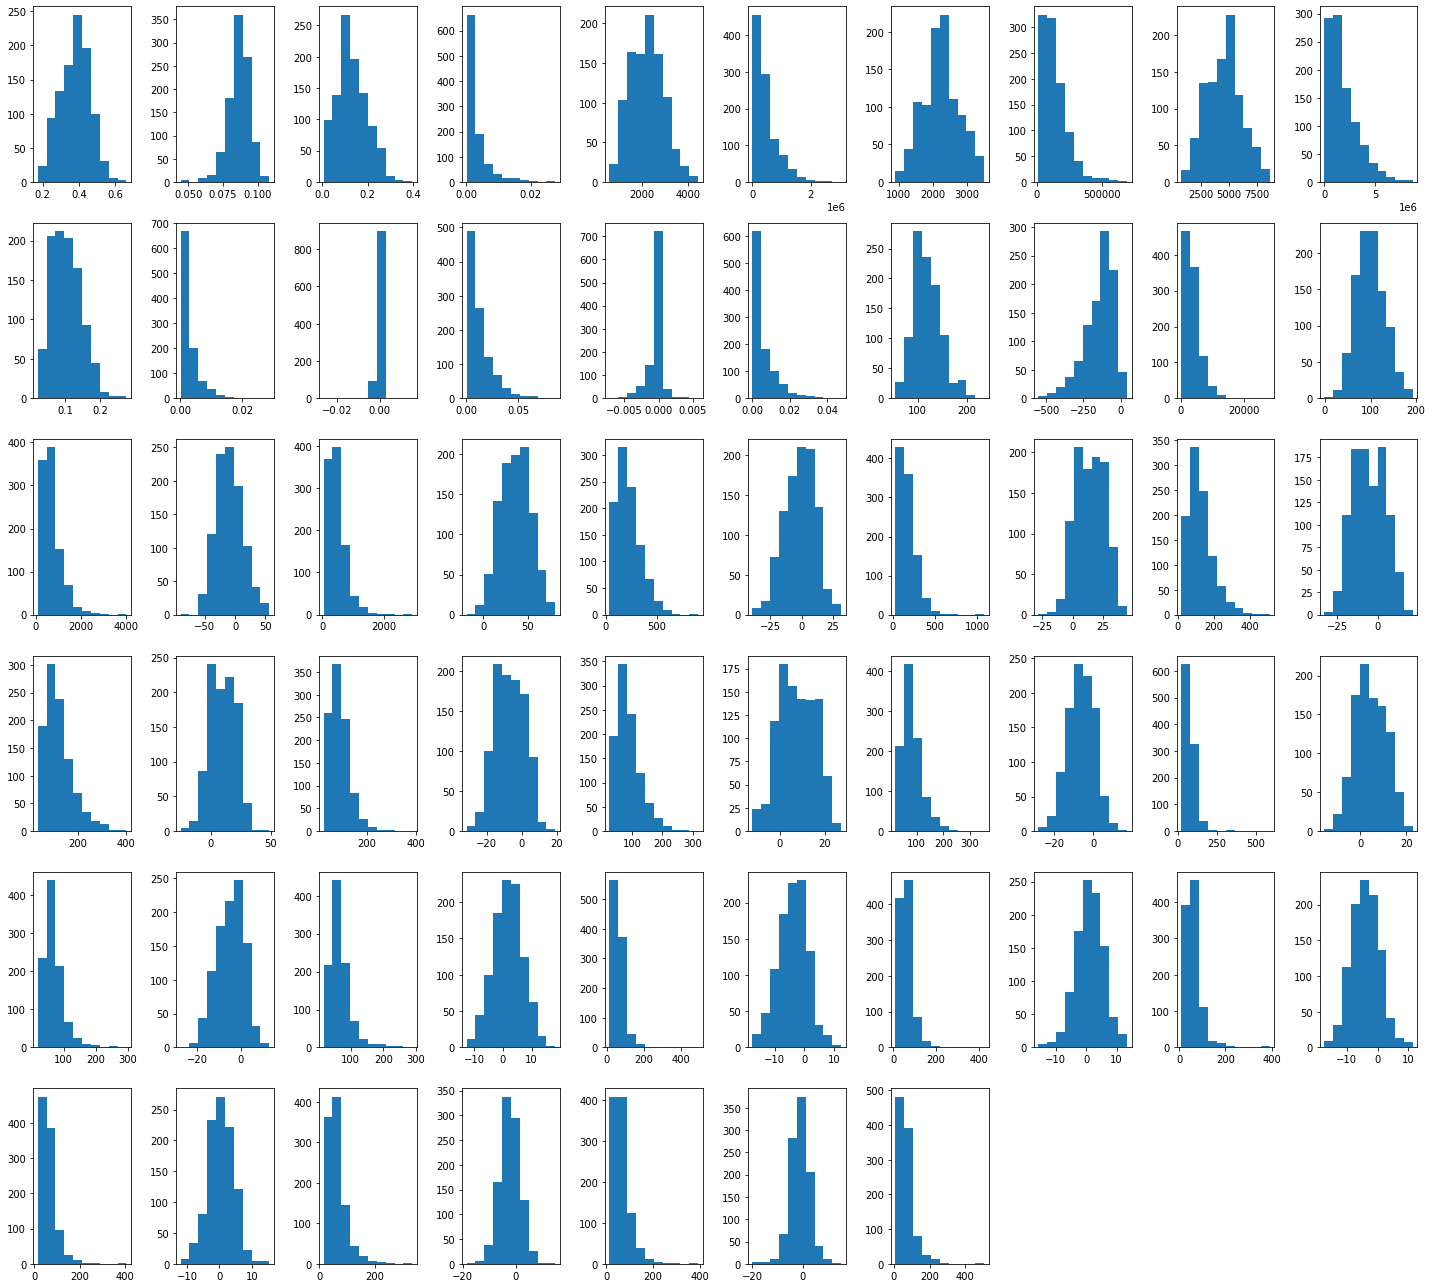

In [ ]:
# 특성 분포
print('feature counts : ',len(df.columns[2:-1]))
plt.figure(figsize=(20,18))
for i, col in enumerate(df.columns[2:-1]) :
  plt.subplot(6,10,i+1)
  plt.hist(df[col])
  plt.tight_layout()

## 머신러닝 접근 방법 (features)
---

### **| 파라미터 추가**


### **| 전처리**


In [ ]:
# label encoding ( blues, disco, ...) -> (0,1,....)
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df['le_label'] = le.fit_transform(df['label'])
print(le.classes_)
df.head()

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label,le_label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues,0
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues,0
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues,0
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues,0
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues,0


In [ ]:
x = df.drop(columns=['filename', 'length', 'label', 'le_label'])
y = df['le_label']
x.shape, y.shape

((1000, 57), (1000,))

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.1, stratify = y, random_state = 0)
print('train', x_train.shape, y_train.shape)
print('test', x_test.shape, y_test.shape)

train (900, 57) (900,)
test (100, 57) (100,)


In [ ]:
# x 정규화
sc = preprocessing.StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_train.shape, x_test.shape

((900, 57), (100, 57))

### **| 학습 - XGBoost**

In [ ]:
! pip install xgboost -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators = 1000)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

Test Acc :  0.79


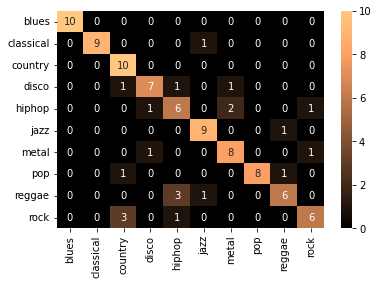

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
y_pred = xgb.predict(x_test)
print('Test Acc : ', accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap = 'copper', xticklabels = le.classes_, yticklabels = le.classes_)
plt.show()

### **| 학습 - DNN**

In [ ]:
# 딥러닝
x = layers.Input(57)
y = layers.Dense(128, activation = 'relu')(x)
y = layers.Dense(64, activation = 'relu')(y)
y = layers.Dropout(0.3)(y)
y = layers.Dense(32, activation = 'relu')(y)
y = layers.Dense(10, activation = 'softmax')(y)
model = models.Model(x,y)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 57)]              0         
                                                                 
 dense (Dense)               (None, 128)               7424      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 18,090
Trainable params: 18,090
Non-trainable p

In [ ]:
from pandas.core.series import validate_bool_kwarg
, validation_curve
model.compile(optimizer ='adam', loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])
history = model.fit(x_train, y_train, epochs = 30,
                    validation_data = (x_test,y_test))

Epoch 1/30
29/29 [==============================] - 1s 9ms/step - loss: 2.1354 - acc: 0.2544 - val_loss: 1.8161 - val_acc: 0.4400
Epoch 2/30
29/29 [==============================] - 0s 4ms/step - loss: 1.7196 - acc: 0.4233 - val_loss: 1.4472 - val_acc: 0.5400
Epoch 3/30
29/29 [==============================] - 0s 3ms/step - loss: 1.4134 - acc: 0.5111 - val_loss: 1.2648 - val_acc: 0.5900
Epoch 4/30
29/29 [==============================] - 0s 3ms/step - loss: 1.2431 - acc: 0.5667 - val_loss: 1.0685 - val_acc: 0.6900
Epoch 5/30
29/29 [==============================] - 0s 3ms/step - loss: 1.0892 - acc: 0.6078 - val_loss: 0.9394 - val_acc: 0.7600
Epoch 6/30
29/29 [==============================] - 0s 4ms/step - loss: 0.9635 - acc: 0.6667 - val_loss: 0.9008 - val_acc: 0.7300
Epoch 7/30
29/29 [==============================] - 0s 3ms/step - loss: 0.9227 - acc: 0.6767 - val_loss: 0.8400 - val_acc: 0.7700
Epoch 8/30
29/29 [==============================] - 0s 3ms/step - loss: 0.8187 - acc: 0.70

In [ ]:
model.evaluate(x_test,y_test)

4/4 [==============================] - 0s 3ms/step - loss: 0.6705 - acc: 0.7900


[0.6704649925231934, 0.7900000214576721]

Text(0, 0.5, 'Loss')

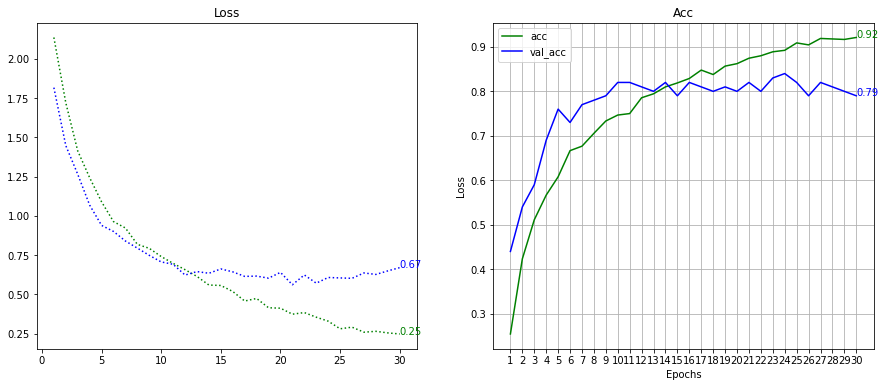

In [ ]:
def draw_lcurve(history) :
  plt.figure(figsize = (15,6))

  epochs = np.arange(1,31)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  plt.subplot(121)
  plt.plot(epochs, loss, linestyle = ':', label = f'train_loss', c = 'green')
  plt.plot(epochs, val_loss, linestyle = ':', label = f'valid_loss', c = 'blue')
  plt.title('Loss')
  a, b = epochs[-1], loss[-1]
  plt.text(a,b,np.round(b,2), c = 'green')
  a, b = epochs[-1], val_loss[-1]
  plt.text(a,b,np.round(b,2), c = 'blue')

  plt.subplot(122)
  plt.plot(epochs, acc, linestyle = '-', label = f'acc', c = 'green')
  plt.plot(epochs, val_acc, linestyle = '-', label = f'val_acc', c = 'blue')
  plt.title('Acc')
  a, b = epochs[-1], acc[-1]
  plt.text(a,b,np.round(b,2), c = 'green')
  a, b = epochs[-1], val_acc[-1]
  plt.text(a,b,np.round(b,2), c = 'blue')
  plt.legend();plt.grid(True);plt.xticks(epochs)
  plt.xlabel('Epochs');plt.ylabel('Loss')
draw_lcurlve(histrory)

## 딥러닝 접근 방법(Audio 원 데이터)
---

In [ ]:
# import librosa # 오디오 분야에서 많이 사용하는 라이브러리
# # Data/genres_original/각클래스별/wav

# new_array = np.zeros([1000,8])

# for i,(f_name,label) in enumerate(zip(df['filename'], df['label'])) :
#   if f_name == 'jazz.00054.wav' : continue
#   dir_path = f'Data/genres_original/{label}/'
#   f_path = f'{dir_path}/{f_name}'
#   # file path로 부터 wav 데이터 읽기
#   y,sr = librosa.load(f_path)
  
#   # print(f_path, y.shape) # zazz 0054 데이터에 오류 있음을 확인
#   # 읽어낸 데이터에서 feature를 추출
#   chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
#   spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
#   spectral_flatness = librosa.feature.spectral_flatness(y=y)
#   tonnetz = librosa.feature.tonnetz(y=y, sr=sr)

#   chroma_cens_mean = np.mean(chroma_cens)
#   chroma_cens_var = np.var(chroma_cens)
#   spectral_contrast_mean = np.mean(spectral_contrast)
#   spectral_contrast_var = np.var(spectral_contrast)
#   spectral_flatness_mean = np.mean(spectral_flatness)
#   spectral_flatness_var = np.var(spectral_flatness)
#   tonnetz_mean = np.mean(tonnetz)
#   tonnetz_var = np.var(tonnetz)

#   new_array[i,0] = chroma_cens_mean
#   new_array[i,1] = chroma_cens_var
#   new_array[i,2] = spectral_contrast_mean
#   new_array[i,3] = spectral_contrast_var
#   new_array[i,4] = spectral_flatness_mean
#   new_array[i,5] = spectral_flatness_var
#   new_array[i,6] = tonnetz_mean
#   new_array[i,7] = tonnetz_var

In [ ]:
new_array.shape

In [ ]:
df['chroma_cens_mean'] = new_array[:, 0]
df['chroma_cens_var'] = new_array[:, 1]
df['spectral_contrast_mean'] = new_array[:, 2]
df['spectral_contrast_var'] = new_array[:, 3]
df['spectral_flatness_mean'] = new_array[:, 4]
df['spectral_flatness_var'] = new_array[:, 5]
df['tonnetz_mean'] = new_array[:, 6]
df['tonnetz_var'] = new_array[:, 7]
df.head(3)

In [ ]:
df = pd.read_csv('/content/wavenet.csv')

In [ ]:
# 추가된 데이터로 전처리
from sklearn.model_selection import train_test_split

wrong_idx = df[ df['filename'] == 'jazz.00054.wav' ].index[0]
print('wrong_idx :', wrong_idx)

x = df.drop(columns=['filename', 'length', 'label', 'le_label'])
x = x.drop([wrong_idx], axis=0)
y = df['le_label']
y = y.drop([wrong_idx], axis = 0)
print(x.shape, y.shape, df.shape)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.1, stratify = y, random_state = 1)

# x 정규화
sc = preprocessing.StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_train.shape, x_test.shape

print('train', x_train.shape, y_train.shape)
print('test', x_test.shape, y_test.shape)

wrong_idx : 554
(999, 65) (999,) (1000, 69)
train (899, 65) (899,)
test (100, 65) (100,)


In [ ]:
  # 데이터 하나 빼기 (df에서 샘플 한 줄 제거) (jazz.00054.wav)
# 머신러닝 돌리기 
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators = 1000)
xgb.fit(x_train, y_train)

y_pred = xgb.predict(x_test)
print('Test Acc : ', accuracy_score(y_test, y_pred))

Test Acc :  0.76


In [ ]:
  # pycaret
! pip install pycaret

In [ ]:
!pip install Jinja2==3.0.1

In [ ]:
import sklearn
sklearn.__version__
import sys
sys.version

In [ ]:
from pycaret.utils import enable_colab
enable_colab()
from pycaret.classification import *
data = setup(data = df, target  = 'label', train_size = 0.8)

,Description,Value
0,session_id,721
1,Target,label
2,Target Type,Multiclass
3,Label Encoded,"blues: 0, classical: 1, country: 2, disco: 3, ..."
4,Original Data,"(1000, 68)"
5,Missing Values,False
6,Numeric Features,66
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='label',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strate...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

In [ ]:
compare_models(sort = 'Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7850,0.9723,0.7871,0.8039,0.7812,0.7610,0.7638,3.670
xgboost,Extreme Gradient Boosting,0.7675,0.9710,0.7689,0.7867,0.7628,0.7415,0.7440,12.746
rf,Random Forest Classifier,0.7587,0.9623,0.7623,0.7662,0.7525,0.7319,0.7341,0.633
et,Extra Trees Classifier,0.7400,0.9612,0.7423,0.7535,0.7350,0.7111,0.7135,0.588
gbc,Gradient Boosting Classifier,0.7188,0.9560,0.7196,0.7458,0.7192,0.6872,0.6899,16.231
lda,Linear Discriminant Analysis,0.6112,0.9283,0.6146,0.6230,0.6003,0.5679,0.5716,0.366
dt,Decision Tree Classifier,0.6062,0.7810,0.6103,0.6211,0.6033,0.5624,0.5645,0.084
nb,Naive Bayes,0.4075,0.8387,0.4145,0.3994,0.3607,0.3414,0.3541,0.056
lr,Logistic Regression,0.3825,0.7959,0.3885,0.3738,0.3578,0.3137,0.3178,3.548
ada,Ada Boost Classifier,0.3062,0.6878,0.3017,0.2283,0.2228,0.2271,0.2453,0.486


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=721, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:compare_models() succesfully completed......................................


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=721, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
lgb = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8000,0.9766,0.8048,0.8133,0.7970,0.7776,0.7795
1,0.8250,0.9734,0.8238,0.8384,0.8226,0.8055,0.8073
2,0.7625,0.9727,0.7621,0.7985,0.7619,0.7357,0.7409
3,0.7750,0.9683,0.7819,0.7959,0.7623,0.7501,0.7542
4,0.7625,0.9678,0.7631,0.7682,0.7595,0.7360,0.7372
5,0.7875,0.9617,0.7917,0.8061,0.7897,0.7638,0.7651
6,0.7750,0.9675,0.7806,0.7763,0.7686,0.7500,0.7514
7,0.8000,0.9864,0.8010,0.8176,0.7964,0.7777,0.7803
8,0.7625,0.9703,0.7599,0.8136,0.7596,0.7355,0.7415


INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 3
INFO:logs:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=721, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:create_model() succesfully completed......................................


In [ ]:
# 하이퍼파라미터 튜닝
lgb_tuned = tune_model(lgb, optimize = 'Accuracy')
lgb_tuned

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7375,0.9780,0.7355,0.7484,0.7313,0.7079,0.7102
1,0.7875,0.9743,0.7877,0.7849,0.7823,0.7636,0.7646
2,0.7750,0.9737,0.7778,0.7960,0.7699,0.7500,0.7537
3,0.8125,0.9646,0.8194,0.8193,0.8083,0.7917,0.7934
4,0.8125,0.9741,0.8117,0.8348,0.8028,0.7916,0.7949
5,0.7500,0.9660,0.7538,0.7681,0.7477,0.7222,0.7244
6,0.7625,0.9716,0.7677,0.7609,0.7544,0.7361,0.7376
7,0.8500,0.9845,0.8542,0.8639,0.8443,0.8333,0.8355
8,0.7000,0.9701,0.7012,0.7497,0.7032,0.6664,0.6706


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 4
INFO:logs:LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
               importance_type='split', learning_rate=0.2, max_depth=-1,
               min_child_samples=51, min_child_weight=0.001, min_split_gain=0.4,
               n_estimators=130, n_jobs=-1, num_leaves=80, objective=None,
               random_state=721, reg_alpha=0.005, reg_lambda=1e-07,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
INFO:logs:tune_model() succesfully completed......................................


LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
               importance_type='split', learning_rate=0.2, max_depth=-1,
               min_child_samples=51, min_child_weight=0.001, min_split_gain=0.4,
               n_estimators=130, n_jobs=-1, num_leaves=80, objective=None,
               random_state=721, reg_alpha=0.005, reg_lambda=1e-07,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
x_train.shape, y_train.shape

((899, 65), (899,))

In [ ]:
from tensorflow.keras import models, layers, utils
# 딥러닝 돌리기
x = layers.Input(65)
y = layers.Dense(128, activation = 'relu')(x)
y = layers.Dense(64, activation = 'relu')(y)
y = layers.Dropout(0.3)(y)
y = layers.Dense(32, activation = 'relu')(y)
y = layers.Dense(10, activation = 'softmax')(y)
model = models.Model(x,y)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 65)]              0         
                                                                 
 dense_12 (Dense)            (None, 128)               8448      
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 10)                330       
                                                                 
Total params: 19,114
Trainable params: 19,114
Non-trainable

In [ ]:
from pandas.core.series import validate_bool_kwarg
, validation_curve
model.compile(optimizer ='adam', loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])
history = model.fit(x_train, y_train, epochs = 30,
                    validation_data = (x_test,y_test))

Epoch 1/30
29/29 [==============================] - 1s 14ms/step - loss: 2.1560 - acc: 0.2202 - val_loss: 1.8742 - val_acc: 0.3500
Epoch 2/30
29/29 [==============================] - 0s 5ms/step - loss: 1.7357 - acc: 0.4004 - val_loss: 1.5378 - val_acc: 0.4100
Epoch 3/30
29/29 [==============================] - 0s 5ms/step - loss: 1.4369 - acc: 0.4772 - val_loss: 1.3478 - val_acc: 0.4700
Epoch 4/30
29/29 [==============================] - 0s 6ms/step - loss: 1.2753 - acc: 0.5762 - val_loss: 1.2275 - val_acc: 0.5500
Epoch 5/30
29/29 [==============================] - 0s 6ms/step - loss: 1.1021 - acc: 0.5873 - val_loss: 1.1619 - val_acc: 0.5700
Epoch 6/30
29/29 [==============================] - 0s 7ms/step - loss: 1.0051 - acc: 0.6652 - val_loss: 1.0940 - val_acc: 0.6300
Epoch 7/30
29/29 [==============================] - 0s 4ms/step - loss: 0.9145 - acc: 0.6941 - val_loss: 1.0211 - val_acc: 0.6200
Epoch 8/30
29/29 [==============================] - 0s 3ms/step - loss: 0.8294 - acc: 0.7

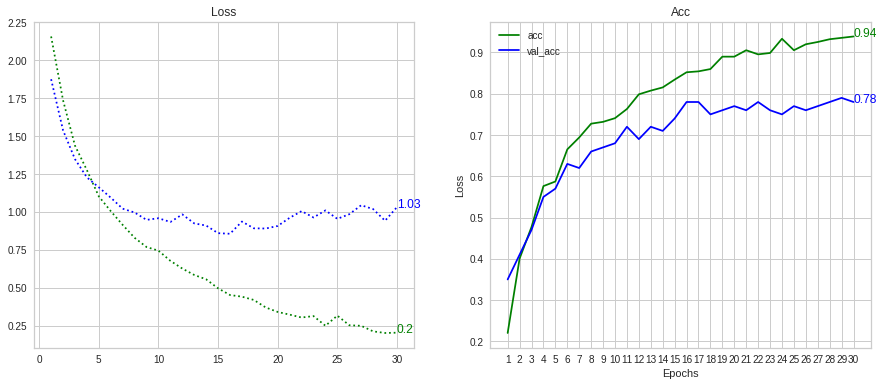

In [ ]:
draw_lcurve(history)